In [12]:
from __future__ import print_function
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

print(__doc__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [13]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Number of Data Samples: %d" % n_samples)
print("Size of a data sample: %d" % n_features)
print("Number of Class Labels: %d" % n_classes)


Number of Data Samples: 1288
Size of a data sample: 1850
Number of Class Labels: 7


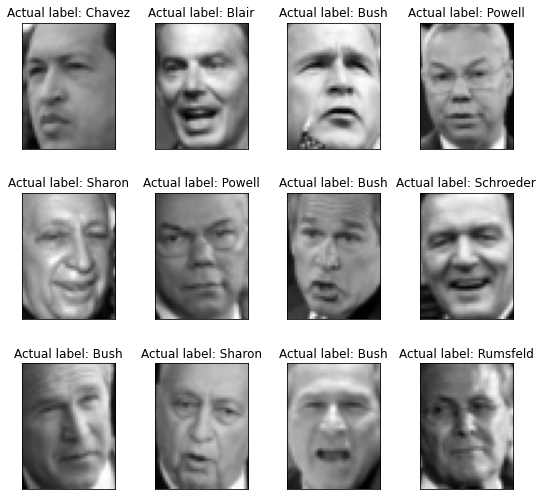

In [23]:
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
	plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
	plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
	for i in range(n_row * n_col):
		plt.subplot(n_row, n_col, i + 1)
		plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
		plt.title(titles[i], size = 12)
		plt.xticks(())
		plt.yticks(())

def true_title(Y, target_names, i):
	true_name = target_names[Y[i]].rsplit(' ', 1)[-1]
	return 'Actual label: % s' % (true_name)

true_titles = [true_title(y, target_names, i)
					for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size = 0.25, random_state = 42)
print("Size of training Data is %d and Testing Data is %d" %(y_train.shape[0], y_test.shape[0]))

Size of training Data is 966 and Testing Data is 322


In [16]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Extracting the top 150 eigenfaces from 966 faces
done in 0.378s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.043s


In [17]:
print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimesnsions of training set = % s and Test Set = % s"%(
		X_train.shape, X_test.shape))

Sample Data point after applying PCA
 [-2.0756037  -1.0457885   2.1269367   0.03682989 -0.7575695  -0.5173725
  0.8555055   1.0519315   0.45774433  0.01347827 -0.03962984  0.63873065
  0.4816695   2.3378174   1.778502    0.13309212 -2.2713673  -4.4568768
  2.0977795  -1.1379213   0.18842584 -0.3349576   1.1254673  -0.32403058
  0.14097327  1.0769353   0.75882345 -0.09975899  3.1199615   0.8837801
 -0.8933796   1.1595848   1.4307339   1.6855845   1.343448   -1.2591248
 -0.63913673 -2.3362706  -0.01363091 -1.4638926  -0.46888053 -1.0547607
 -1.3329383   1.1363641   2.222338   -1.8014646  -0.30636504 -1.0281849
  4.7734575   3.459864    1.9260218  -1.351471   -0.25878748  2.010361
 -1.0559801   0.36075166  1.1706759   0.75725687  0.9005063   0.59968513
 -0.46598402  2.0973654   1.3455186   1.9318786   5.0672383  -0.7067567
  0.6073314  -0.8990152  -0.2144492  -2.108161   -1.6813021  -0.1981089
 -1.7476106  -3.0534985   2.0531428   0.3952974   0.12658605  1.2082257
 -0.79669964 -1.3876475 

In [18]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Done in 45.562s
Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [19]:
print("Predicting people's names: ")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names: 
done in 0.083s
                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.46      0.60        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.82      0.98      0.89       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.85       322
        macro avg       0.91      0.72      0.78       322
     weighted avg       0.86      0.85      0.84       322

[[  6   2   0   5   0   0   0]
 [  1  52   0   7   0   0   0]
 [  0   2  17   8   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   3   0   3   1   8   0]
 [  0   2   1   6   0   0  27]]


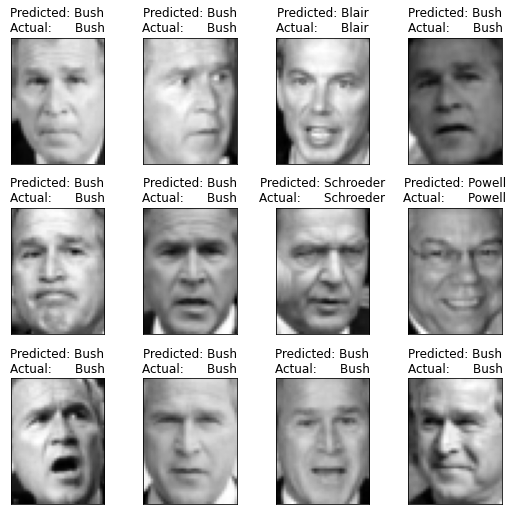

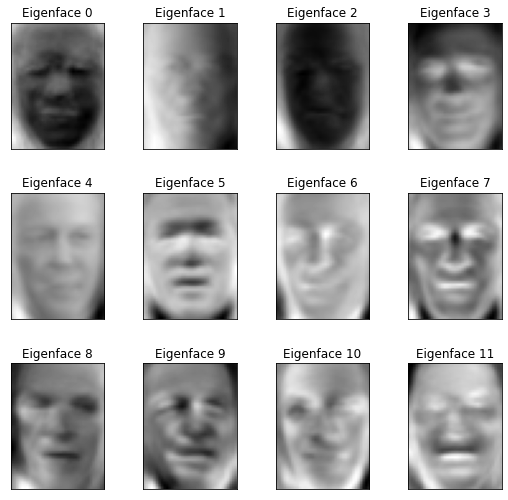

In [22]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'Predicted: %s\nActual:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

eigenface_titles = ["Eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()